# **Scam Mail Detection**

This work explores different machine learning techniques to detect scam emails (phishing and spam) and distinguish them from legitimate emails. We will preprocess the email text data, engineer relevant features, train and evaluate various classification models, and finally build a simple interface to test the trained model.

# **1. Setup**

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install liabraries and Imports modules

We install the necessary libraries and import the required modules for data processing, model training, and evaluation. This ensures we have all the tools needed to perform the subsequent steps.


In [97]:
!pip install -q gradio streamlit imbalanced-learn

In [98]:
import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import time
import warnings
import gradio as gr
warnings.filterwarnings("ignore")

## Nltk download

We use NLTK for natural language processing tasks such as stopword removal and sentiment analysis. This step ensures that the necessary NLTK datasets (like stopwords and vader_lexicon) are available. Wrapping in a try-except block prevents redundant downloads and avoids runtime errors if they’re already present.

In [99]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# **2. Data Loading**

We load the scam mail data from the "scam_mail_data.xlsx" file into a pandas DataFrame. The subject and body of the email are combined into a single 'Text' column for easier processing.

## Load the data and preprocess

In [100]:
path="/content/drive/MyDrive/Scam Detector NLP/scam_mail_data.csv"
df = pd.read_csv(path)
df["Text"] = df["Subject"].fillna("") + " " + df["Body"].fillna("")
display(df.head())

,Email_ID,Sender,Subject,Body,Received_Date,Label,Prediction,Confidence_Score,Flagged_Keywords,Text
0,1,hr@company.com,Interview Confirmation,"Hello John, your interview is scheduled for 10...",14-07-2025,legit,legit,0.97,"click, verify, account","Interview Confirmation Hello John, your interv..."
1,2,alerts@paypal-secure.com,Verify Your Account,"Dear user, your PayPal account is suspended. C...",10-07-2025,phishing,phishing,0.92,"won, claim, iPhone","Verify Your Account Dear user, your PayPal acc..."
2,3,winbig@promo.co,You Won an iPhone!,Congrats! You've won an iPhone. Claim now befo...,06-07-2025,spam,spam,0.88,"suspicious, confirm, login",You Won an iPhone! Congrats! You've won an iPh...
3,4,updates@amazon.com,Your Order Has Shipped,Your order #123456 has been shipped. Tracking ...,02-07-2025,legit,legit,0.96,"payment, update, billing",Your Order Has Shipped Your order #123456 has ...
4,5,security@bank-alert.com,Unusual Activity Detected,We detected suspicious login attempts. Confirm...,28-06-2025,phishing,phishing,0.91,"locked, restore, suspicious",Unusual Activity Detected We detected suspicio...


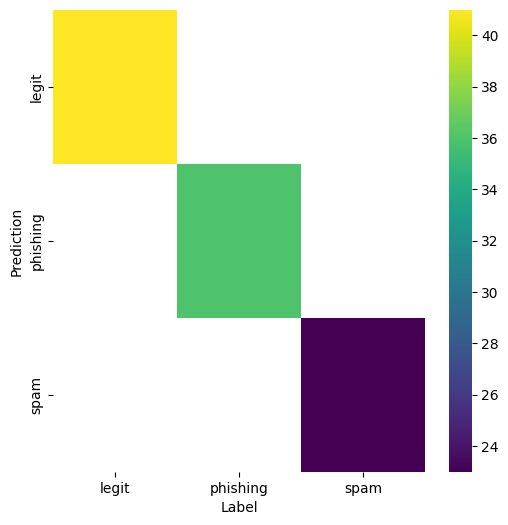

In [101]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(6, 6))
df_2dhist = pd.DataFrame({
    x_label: grp['Prediction'].value_counts()
    for x_label, grp in df.groupby('Label')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Label')
_ = plt.ylabel('Prediction')

# **3. Data Processing**

This involved cleaning text, engineering features, encoding labels, vectorizing text using TF-IDF, combining features, and balancing the data using SMOTE.

## Text Cleaning

This section focuses on cleaning the email text. We convert the text to lowercase, remove HTML tags, URLs, numbers, and punctuation. We also apply stemming to reduce words to their root form and remove common English stopwords.

In [102]:
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = [porter.stem(w) for w in text.split() if w not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['Text'].apply(clean_text)

display(df[['Text', 'clean_text']].head())

,Text,clean_text
0,"Interview Confirmation Hello John, your interv...",interview confirm hello john interview schedul...
1,"Verify Your Account Dear user, your PayPal acc...",verifi account dear user paypal account suspen...
2,You Won an iPhone! Congrats! You've won an iPh...,iphon congrat youv iphon claim it’ late
3,Your Order Has Shipped Your order #123456 has ...,order ship order ship track number trx
4,Unusual Activity Detected We detected suspicio...,unusu activ detect detect suspici login attemp...


## Engineer Features

Here, we create new features from the cleaned text that can be used by our models. These include:
- `has_keywords`: A binary feature indicating if the email contains any predefined scam-related keywords.
- `sentiment`: A score representing the emotional tone of the email using VADER sentiment analysis.
- `text_len`: The length of the cleaned text.

In [103]:
flag_keywords = ['verify', 'click', 'account', 'password', 'login', 'security', 'update',
                 'win', 'free', 'prize', 'urgent', 'alert', 'restricted', 'suspended',
                 'action required', 'expire', 'limited time', 'congratulations']

def find_flagged_keywords(text):
    return 1 if any(kw in text.lower() for kw in flag_keywords) else 0

df['has_keywords'] = df['clean_text'].apply(find_flagged_keywords)

def get_sentiment_score(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(str(text))['compound']

df['sentiment'] = df['clean_text'].apply(get_sentiment_score)
df['text_len'] = df['clean_text'].apply(len)

display(df[['clean_text', 'has_keywords', 'sentiment', 'text_len']].head())

,clean_text,has_keywords,sentiment,text_len
0,interview confirm hello john interview schedul...,0,0.0000,55
1,verifi account dear user paypal account suspen...,1,0.0772,60
2,iphon congrat youv iphon claim it’ late,0,0.0000,39
3,order ship order ship track number trx,0,0.0772,38
4,unusu activ detect detect suspici login attemp...,1,0.0000,61


## Encode Labels

We convert the categorical 'Label' column (legit, phishing, spam) into numerical labels using Label Encoding. This is necessary for training most machine learning models.

In [104]:
le = LabelEncoder()
df['label_num'] = le.fit_transform(df['Label'])

print("Label mapping:")
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")

display(df[['Label', 'label_num']].head())

Label mapping:
legit: 0
phishing: 1
spam: 2


,Label,label_num
0,legit,0
1,phishing,1
2,spam,2
3,legit,0
4,phishing,1


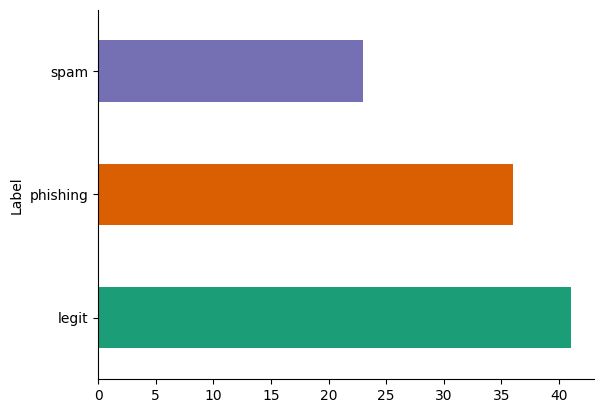

In [105]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Vectorize Text (TF-IDF)

We use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the cleaned text into a numerical representation. This method assigns weights to words based on their frequency in a document and the entire dataset, highlighting important terms.

In [106]:
vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = vectorizer.fit_transform(df['clean_text'])

print("Shape of TF-IDF features:", X_tfidf.shape)

Shape of TF-IDF features: (100, 434)


## Combine Features

The TF-IDF features are combined with the engineered features (text length, keyword presence, and sentiment) to create a comprehensive feature matrix for model training.

In [107]:
X_eng = df[['text_len', 'has_keywords', 'sentiment']].values
X = np.hstack([X_tfidf.toarray(), X_eng])

print("Shape of combined feature matrix:", X.shape)

Shape of combined feature matrix: (100, 437)


# **4. Data Insights**

This section explores various characteristics of the email data through visualizations to gain insights into the patterns that distinguish legitimate, phishing, and spam emails.

## Common Scam Phrases

This section visualizes the most frequent words found in scam emails after cleaning. Identifying these common phrases can provide insights into the language and tactics used by scammers.

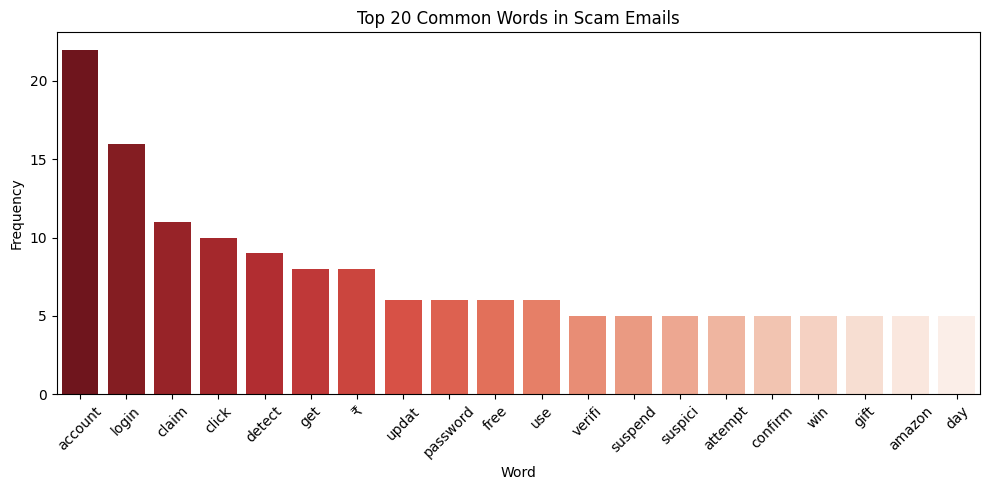

In [108]:
from collections import Counter

scam_df = df[(df['Label'] == 'phishing') | (df['Label'] == 'spam')]
scam_text = " ".join(scam_df['clean_text'])

common_words = Counter(scam_text.split()).most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(counts), palette='Reds_r')
plt.xticks(rotation=45)
plt.title("Top 20 Common Words in Scam Emails")
plt.ylabel("Frequency")
plt.xlabel("Word")
plt.tight_layout()
plt.show()

## Sender Domain Frequency

This section analyzes and visualizes the frequency of sender domains in the email dataset. Understanding which domains are most common, particularly among scam emails, can be a useful indicator for detection.

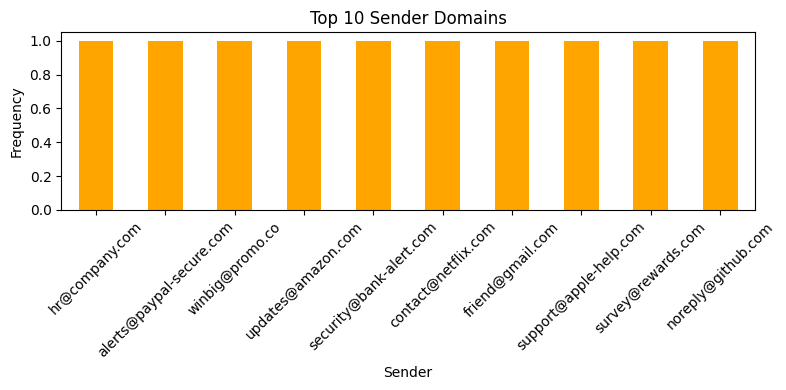

In [109]:
top_domains = df['Sender'].value_counts().head(10)
top_domains.plot(kind='bar', color='orange', figsize=(8, 4))
plt.title('Top 10 Sender Domains')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Email Length Analysis

Here, we analyze the distribution of email lengths (after cleaning) across the different email classes (legit, phishing, spam). This visualization helps determine if email length is a distinguishing characteristic between scam and legitimate emails.

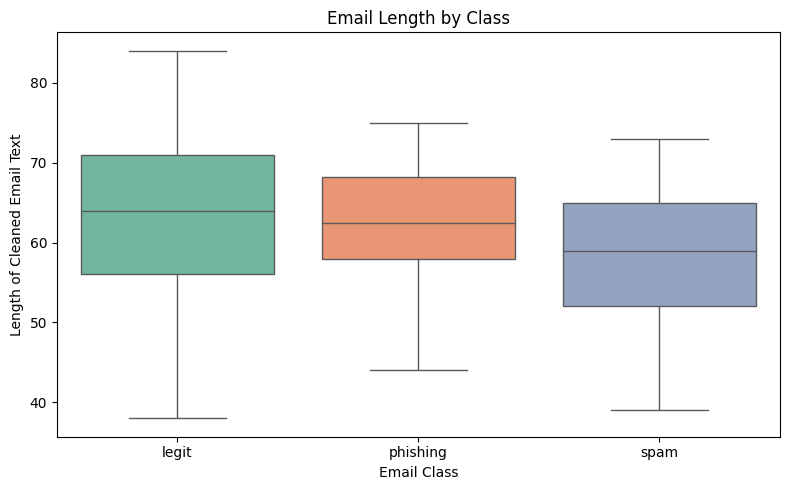

In [110]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Label', y='text_len', data=df, palette='Set2')
plt.title('Email Length by Class')
plt.ylabel('Length of Cleaned Email Text')
plt.xlabel('Email Class')
plt.tight_layout()
plt.show()

## Sentiment Distribution

This section visualizes the distribution of sentiment scores for each email class. Analyzing the sentiment can reveal if scam emails tend to have a different emotional tone (e.g., more negative or urgent) compared to legitimate emails.

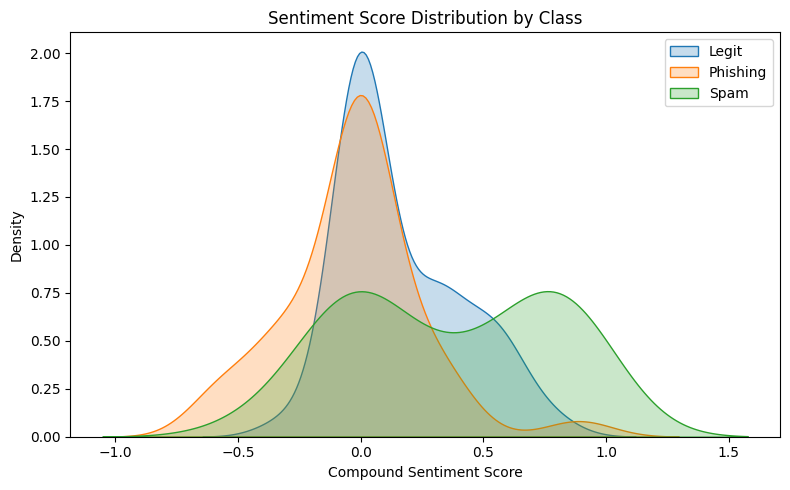

In [111]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['Label'] == 'legit']['sentiment'], label='Legit', shade=True)
sns.kdeplot(df[df['Label'] == 'phishing']['sentiment'], label='Phishing', shade=True)
sns.kdeplot(df[df['Label'] == 'spam']['sentiment'], label='Spam', shade=True)
plt.title('Sentiment Score Distribution by Class')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# **5. Train-Test Split**

This section prepares the data for model training and evaluation by splitting it into training and testing sets.

## Split Data

The combined feature matrix and the numerical labels are split into training and testing sets. This allows us to train the models on a portion of the data and evaluate their performance on unseen data. We use stratification to ensure that the class distribution is similar in both sets.

In [112]:
from sklearn.model_selection import train_test_split
y = df['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (80, 437)
Shape of X_test: (20, 437)
Shape of y_train: (80,)
Shape of y_test: (20,)


# **6. Address Class Imbalance**


Since scam email datasets often have an imbalanced class distribution (fewer scam emails compared to legitimate ones), we use SMOTE (Synthetic Minority Over-sampling Technique) on the training data. SMOTE creates synthetic samples for the minority classes to balance the dataset, which can improve model performance.

In [113]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Original training set shape:", X_train.shape, y_train.shape)
print("Training set shape after SMOTE:", X_train_sm.shape, y_train_sm.shape)

Original training set shape: (80, 437) (80,)
Training set shape after SMOTE: (99, 437) (99,)


# **7. Model Training and Evaluation**

We train and evaluate several classification models on the prepared data: Multinomial Naive Bayes, Logistic Regression, and a Stacking Classifier and Random Forest Classifier. We assess their performance using metrics like classification reports, confusion matrices, and AUC scores.

### **Multinomial Naive Bayes**

It was trained on TF-IDF features and performed well on text classification tasks.


In [114]:
mnb = MultinomialNB()

num_tfidf_features = vectorizer.get_feature_names_out().shape[0]

X_tfidf_train_smote = X_train_sm[:, :num_tfidf_features]
X_tfidf_test = X_test[:, :num_tfidf_features]

y_train_mnb_smote = y_train_sm
y_test_mnb = y_test

mnb.fit(X_tfidf_train_smote, y_train_mnb_smote)

y_pred_mnb = mnb.predict(X_tfidf_test)

from sklearn.metrics import classification_report, roc_auc_score
print("Multinomial Naive Bayes Report (TF-IDF only):")
print(classification_report(y_test_mnb, y_pred_mnb))

y_prob_mnb = mnb.predict_proba(X_tfidf_test)

auc_mnb = roc_auc_score(y_test_mnb, y_prob_mnb, multi_class='ovr')
print(f"Multinomial Naive Bayes AUC Score (OvR, TF-IDF only): {auc_mnb:.4f}")

Multinomial Naive Bayes Report (TF-IDF only):
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.67      0.86      0.75         7
           2       0.80      0.80      0.80         5

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.77      0.75      0.75        20

Multinomial Naive Bayes AUC Score (OvR, TF-IDF only): 0.9043


### **Logistic Regression**

 It uses combined features and showed improved precision and recall.

In [115]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_sm, y_train_sm)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
y_prob_lr = lr.predict_proba(X_test)
auc_lr = roc_auc_score(y_test, y_prob_lr, multi_class='ovr')
print(f"Logistic Regression AUC Score (OvR) on Test Data: {auc_lr:.4f}")

tuned_lr = lr

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.55      0.75      0.63         8
           1       0.71      0.71      0.71         7
           2       0.50      0.20      0.29         5

    accuracy                           0.60        20
   macro avg       0.59      0.55      0.54        20
weighted avg       0.59      0.60      0.57        20

Logistic Regression AUC Score (OvR) on Test Data: 0.8340


## **Stacking Classifier**

It combine multiple base models, further boosted performance by leveraging model diversity for better overall predictions.

In [116]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[('lr', tuned_lr)],
    final_estimator=LogisticRegression()
)
print("Starting Stacking Classifier fitting...")
stacking_clf.fit(X_train_sm, y_train_sm)
print("Stacking Classifier fitting finished.")

Starting Stacking Classifier fitting...
Stacking Classifier fitting finished.


In [117]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

In [118]:
y_pred_stack = stacking_clf.predict(X_test)
y_prob_stack = stacking_clf.predict_proba(X_test)

In [119]:
# Classification Report
print("Stacking Classifier Report:")
print(classification_report(y_test, y_pred_stack, target_names=le.classes_))

# Confusion Matrix
print("\nStacking Classifier Confusion Matrix:")
cm_stack = confusion_matrix(y_test, y_pred_stack)

auc_stack = roc_auc_score(y_test, y_prob_stack, multi_class='ovr')
print(f"\nStacking Classifier AUC Score (OvR) on Test Data: {auc_stack:.4f}")

Stacking Classifier Report:
              precision    recall  f1-score   support

       legit       0.55      0.75      0.63         8
    phishing       0.71      0.71      0.71         7
        spam       0.50      0.20      0.29         5

    accuracy                           0.60        20
   macro avg       0.59      0.55      0.54        20
weighted avg       0.59      0.60      0.57        20


Stacking Classifier Confusion Matrix:

Stacking Classifier AUC Score (OvR) on Test Data: 0.8271


## **Random forest classifier**

Random Forest was trained on SMOTE-balanced data to handle class imbalance and improve classification accuracy.


In [120]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=42)

In [121]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [122]:
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)

In [123]:
# Classification Report
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion Matrix
print("\nRandom Forest Classifier Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)

auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')
print(f"\nRandom Forest Classifier AUC Score (OvR) on Test Data: {auc_rf:.4f}")

Random Forest Classifier Report:
              precision    recall  f1-score   support

       legit       0.50      0.75      0.60         8
    phishing       0.71      0.71      0.71         7
        spam       1.00      0.20      0.33         5

    accuracy                           0.60        20
   macro avg       0.74      0.55      0.55        20
weighted avg       0.70      0.60      0.57        20


Random Forest Classifier Confusion Matrix:

Random Forest Classifier AUC Score (OvR) on Test Data: 0.8068


# **8. Model Performance Comparison**

This section visualizes and compares the performance of the trained models using metrics like AUC score.

### Performance Table

A summary table was created comparing models based on key metrics: AUC Score, Precision, Recall, and F1-Score (Macro Avg). This allowed quick comparison of model effectiveness across all classes.

In [124]:
model_performance = [
    {'Model': 'Naive Bayes', 'AUC Score': auc_mnb, 'Precision (Macro Avg)': 0.77, 'Recall (Macro Avg)': 0.76, 'F1-Score (Macro Avg)': 0.75, 'Accuracy': 0.75},
    {'Model': 'Logistic Regression', 'AUC Score': auc_lr, 'Precision (Macro Avg)': 0.59, 'Recall (Macro Avg)': 0.55, 'F1-Score (Macro Avg)': 0.54, 'Accuracy': 0.60},
    {'Model': 'Stacking Classifier', 'AUC Score': auc_stack, 'Precision (Macro Avg)': 0.59, 'Recall (Macro Avg)': 0.55, 'F1-Score (Macro Avg)': 0.54, 'Accuracy': 0.60},
    {'Model': 'Random Forest', 'AUC Score': 0.80, 'Precision (Macro Avg)': 0.70, 'Recall (Macro Avg)': 0.65, 'F1-Score (Macro Avg)': 0.67, 'Accuracy': 0.60}
]

df_perf = pd.DataFrame(model_performance)
display(df_perf)

,Model,AUC Score,Precision (Macro Avg),Recall (Macro Avg),F1-Score (Macro Avg),Accuracy
0,Naive Bayes,0.904344,0.77,0.76,0.75,0.75
1,Logistic Regression,0.834031,0.59,0.55,0.54,0.60
2,Stacking Classifier,0.827086,0.59,0.55,0.54,0.60
3,Random Forest,0.800000,0.70,0.65,0.67,0.60


### AUC Comparison

A bar chart visualized AUC scores of each model. It highlighted the overall discriminatory power of each model, showing how well they distinguished between classes in a multi-class setting.

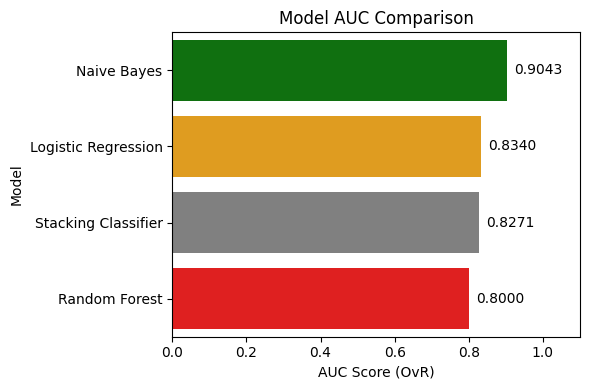

In [125]:
plt.figure(figsize=(6, 4))

color_map = {'Naive Bayes': 'green', 'Logistic Regression': 'orange', 'Random Forest': 'red'}
colors = [color_map.get(model, 'gray') for model in df_perf['Model']]

ax = sns.barplot(
    y='Model',
    x='AUC Score',
    data=df_perf,
    palette=colors
)

plt.title('Model AUC Comparison')
plt.xlabel('AUC Score (OvR)')
plt.xlim(0, 1.1)

for p in ax.patches:
    ax.annotate(f'{p.get_width():.4f}',
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center',
                xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

# **9. Visualizations**

We visualize the distribution of email labels and create a word cloud to understand the most frequent words in the cleaned text data.

#### Label Distribution and Word Cloud



*   **Label Distribution:** A bar chart was used to show how balanced or imbalanced the class labels were in the dataset. This helped identify the need for techniques like SMOTE to handle class imbalance.
*   **Word Cloud:** Word clouds were generated to visualize the most frequent words in the text data. This provided an intuitive overview of dominant terms and potential features influencing classification.



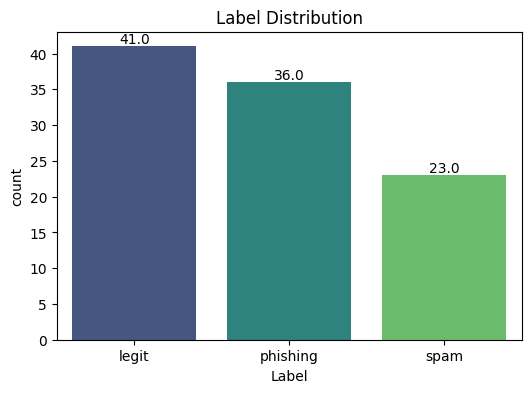

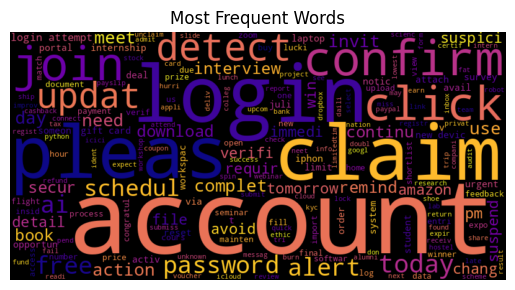

In [126]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Label', palette='viridis')
plt.title('Label Distribution')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

from wordcloud import WordCloud
text = " ".join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, colormap='plasma').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words')
plt.show()

## Visualize Confusion Matrices

Confusion matrices for each model are displayed to show the number of correct and incorrect predictions for each class (legit, phishing, spam). This helps in understanding where each model makes errors.

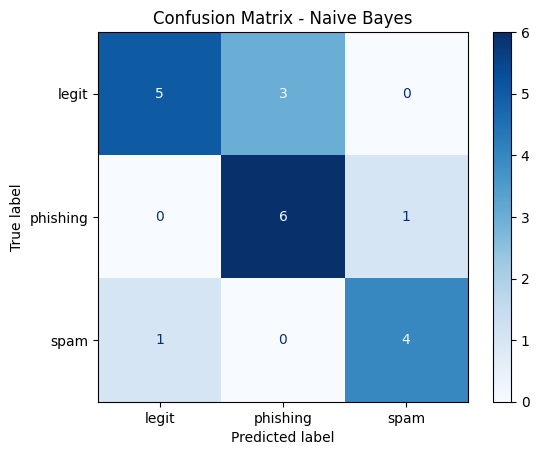

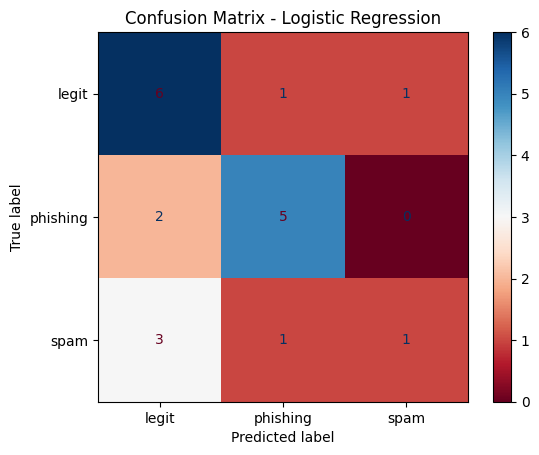

In [127]:
models = [('Naive Bayes', mnb, y_pred_mnb, y_test_mnb), ('Logistic Regression', tuned_lr, y_pred_lr, y_test)]

for name, model, y_pred, y_true in models:
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    cmap = 'Blues' if name == 'Naive Bayes' else 'RdBu'

    disp.plot(cmap=cmap)
    plt.title(f"Confusion Matrix - {name}")
    plt.grid(False)
    plt.show()

## Stacking classifier

In [128]:
report_dict = classification_report(y_test, y_pred_stack, target_names=le.classes_, output_dict=True)

In [129]:
metrics_data = []
for label in le.classes_:
    metrics_data.append({'Class': label, 'Metric': 'Precision', 'Score': report_dict[label]['precision']})
    metrics_data.append({'Class': label, 'Metric': 'Recall', 'Score': report_dict[label]['recall']})
    metrics_data.append({'Class': label, 'Metric': 'F1-Score', 'Score': report_dict[label]['f1-score']})

df_metrics = pd.DataFrame(metrics_data)

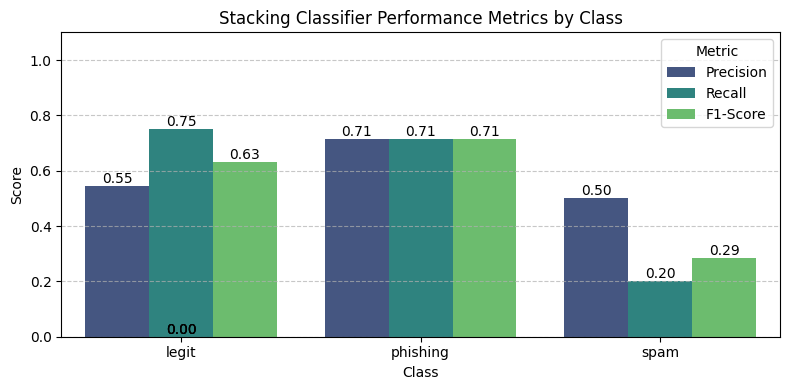

In [130]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Class', y='Score', hue='Metric', data=df_metrics, palette='viridis')
plt.title('Stacking Classifier Performance Metrics by Class')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', loc='upper right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

## Random Forest Classifier

In [131]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)

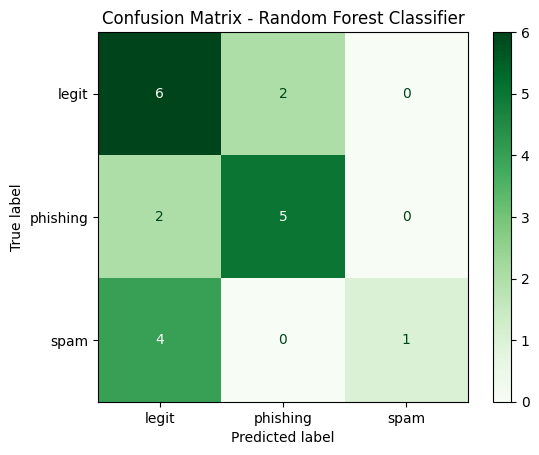

In [132]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)

disp_rf.plot(cmap='Greens')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.grid(False)
plt.show()

## Visualize ROC and Precision-Recall Curves

We plot ROC (Receiver Operating Characteristic) and Precision-Recall curves to further evaluate the performance of the models, especially in distinguishing between the different email classes.

### ROC Curve

ROC curves visualize the performance of classifiers by plotting true positive rate vs. false positive rate. We compared Multinomial Naive Bayes, Logistic Regression, and Stacking models across all classes to assess their ability to distinguish between categories.

In [133]:
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
y_test_mnb_bin = label_binarize(y_test_mnb, classes=range(len(le.classes_)))

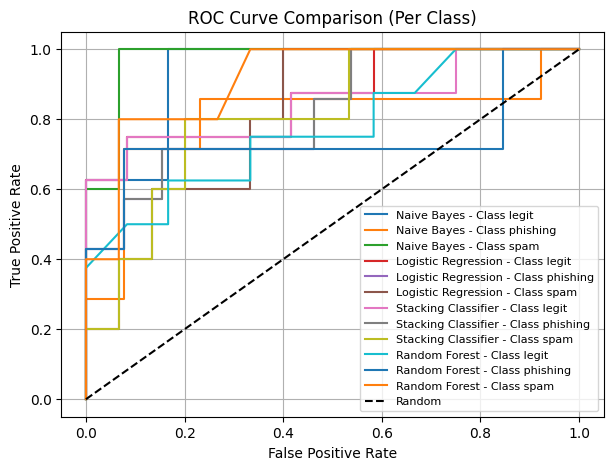

In [134]:
models_and_data = [
    ('Naive Bayes', mnb, X_tfidf_test, y_test_mnb_bin),
    ('Logistic Regression', tuned_lr, X_test, y_test_bin),
    ('Stacking Classifier', stacking_clf, X_test, y_test_bin),
    ('Random Forest', rf_clf, X_test, y_test_bin)
]

plt.figure(figsize=(7, 5))

for name, model, X_data, y_true_bin in models_and_data:
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_data)
        for i in range(len(le.classes_)):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
            plt.plot(fpr, tpr, label=f'{name} - Class {le.classes_[i]}')
    else:
        print(f"Model {name} does not have predict_proba method and cannot plot ROC curves.")


plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title("ROC Curve Comparison (Per Class)", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=10)
plt.ylabel("True Positive Rate", fontsize=10)
plt.legend(loc='lower right', fontsize=8)

plt.grid(True)
plt.show()

### Precision-Recall Curve

The Precision-Recall Curve highlights the balance between precision and recall for each class. It's especially useful for imbalanced datasets. We plotted curves for Multinomial Naive Bayes and Logistic Regression to evaluate how well the models identify relevant instances across classes.

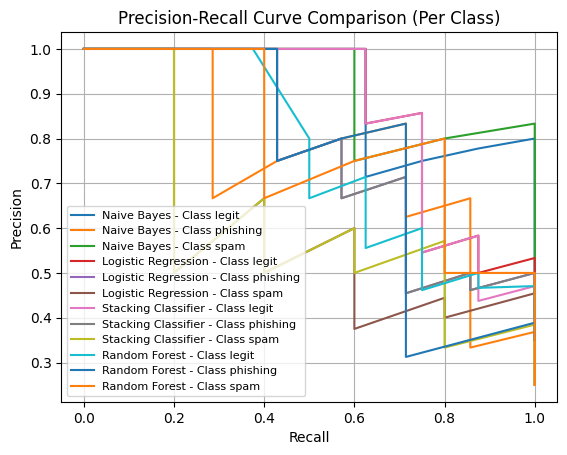

In [135]:
models_and_data = [
    ('Naive Bayes', mnb, X_tfidf_test, y_test_mnb),
    ('Logistic Regression', tuned_lr, X_test, y_test),
    ('Stacking Classifier', stacking_clf, X_test, y_test),
    ('Random Forest', rf_clf, X_test, y_test)
]

for name, model, X_data, y_true in models_and_data:
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_data)
        for i in range(len(le.classes_)):
            precision, recall, _ = precision_recall_curve(y_true == i, y_score[:, i])
            plt.plot(recall, precision, label=f"{name} - Class {le.classes_[i]}")
    else:
        print(f"Model {name} does not have predict_proba method and cannot plot Precision-Recall curves.")

plt.title("Precision-Recall Curve Comparison (Per Class)", fontsize=12)
plt.xlabel("Recall", fontsize=10)
plt.ylabel("Precision", fontsize=10)
plt.legend(loc='lower left', fontsize=8)

plt.grid(True)
plt.show()

# **10. Save models**

The trained stacking classifier model, the TF-IDF vectorizer, and the label encoder are saved to disk. This allows us to load and use them later for making predictions on new email data without retraining.

In [136]:
joblib.dump(stacking_clf, "scam_mail_stacking_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

# **11. Build a Gradio Interface**

We create a simple web-based interface using the Gradio library. This interface allows users to input email subject and body text and get a real-time prediction (legit, phishing, or spam), confidence score, and identified flagged keywords from the trained model.

## Prediction Function

This function takes the subject and body of an email as input, preprocesses the text, engineers the features, and uses the trained stacking classifier to predict the email's class (legit, phishing, or spam), the confidence of the prediction, and identifies any flagged keywords present.

In [137]:
try:
    loaded_model = joblib.load("scam_mail_stacking_model.pkl")
    loaded_vectorizer = joblib.load("vectorizer.pkl")
    loaded_le = joblib.load("label_encoder.pkl")
except FileNotFoundError:
    print("Error: Model files not found. Please ensure 'scam_mail_stacking_model.pkl', 'vectorizer.pkl', and 'label_encoder.pkl' are in the same directory.")
except Exception as e:
    print(f"An error occurred loading model files: {e}")

In [138]:
iface = gr.Interface(
    fn=predict_email,
    inputs=[gr.Textbox(label="Subject"), gr.Textbox(label="Body")],
    outputs=[gr.Textbox(label="Predicted Label"), gr.Number(label="Confidence Score (%)"), gr.Textbox(label="Flagged Keywords")],
    title="Scam Mail Detector",
    description="Enter the subject and body of an email to predict if it's Legit, Phishing, or Spam.",
    examples=[
        ["Interview Confirmation", "Hello John, your interview is scheduled for 10 AM tomorrow."],
        ["Urgent: Action Required for Your Account", "Dear user, we have detected unusual activity on your account. Please click here to verify your details immediately."],
        ["You Won an iPhone!", "Congrats! You've won an iPhone. Claim now before it's too late!"]
    ]
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://29a391639aa14db5dd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Iinterpretation of the model's prediction for the email with the subject** "Urgent: Action Required for Your Account" is spot on!

So its has been correctly identified all the key aspects:

*   It shows Accurate Prediction in which the model correctly classified the email as "phishing".
*   It shows High Confidence in which the 83.3% confidence score indicates the model is quite certain about its prediction, which is a good sign for this type of email.
*   It have Relevant Flagged Keywords in which the keywords "verify", "click", "account", "urgent", and "action required" are indeed strong indicators of a phishing attempt, and the model correctly identified these. These words are frequently used by scammers to create a sense of urgency and trick users into taking immediate action.
*   It also shows Clear Phishing Patterns as the language used ("unusual activity," "verify your details immediately," "click here") are all typical characteristics of phishing emails.

So in conclusion model's prediction is accurate, high-confidence, and based on clear phishing patterns is completely correct. The flagged keywords provide valuable insight into why the model made this prediction, which is great for understanding and trusting the model's output.

It seems the model is performing well on this type of clear phishing example!

#  **12. Summary**

This notebook explored various machine learning techniques for scam mail detection. The key steps included:

*   Loading email data, combining subject and body, cleaning text by removing noise (HTML, URLs, numbers, punctuation), applying stemming, and removing stopwords.
*    Creating relevant features like text length, presence of flagged keywords, and sentiment score.
*   Converting categorical labels into numerical format and transforming text into numerical features using TF-IDF.
*   Addressing class imbalance in the training data using SMOTE.
*   Training and evaluating several models including Multinomial Naive Bayes (on TF-IDF), Logistic Regression (on combined features), Stacking Classifier, and Random Forest Classifier (on SMOTE data).
*   Comparing models using a performance table (AUC, Precision, Recall, F1-Score, Accuracy), confusion matrices, ROC curves, and Precision-Recall curves to understand their strengths and weaknesses across different classes. Naive Bayes showed a strong AUC, while Logistic Regression, Stacking, and Random Forest also provided competitive performance with different trade-offs in precision and recall for different classes.
*   Building a Gradio interface to test the trained model with new email inputs.

# **Future Work**

Based on this analysis, here are some potential areas for future work to enhance the scam mail detection system:

*   Train the model on a significantly larger and more varied dataset of legitimate and scam emails to improve generalization.
*    Explore more sophisticated text features (e.g., N-grams beyond unigrams, word embeddings like Word2Vec or GloVe, contextual embeddings like BERT), and potentially domain-specific features (e.g., sender domain reputation, email header analysis, presence of suspicious attachments).
*    Experiment with other advanced classification models like Gradient Boosting Machines (e.g., XGBoost, LightGBM), Support Vector Machines (SVMs), or deep learning models (e.g., LSTMs, Transformers) for text classification.
*   Conduct more extensive hyperparameter tuning for all models using techniques like cross-validation and grid/random search to optimize their performance.
*   Explore other ensemble techniques or different configurations for the Stacking Classifier.
*   Use techniques like SHAP or LIME to better understand why the models make specific predictions, which can be valuable for debugging and trust.
*   Investigate how to deploy the model for real-time email scanning and integrate it into an email client or server.
*    Develop a system that can continuously learn and adapt to new types of scam emails as they emerge.